In [ ]:
import openai
import langchain
import pinecone

from langchain.document_loaders import PyPDFDirectoryLoader #as my pdf is inside directory, I am using this

# next step after loading PDf, next step is to create text chunk: text_splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

#next step: convert chunks into vector: embeddings
from langchain.embeddings.openai import OpenAIEmbeddings

#To create vector DB, need to import this library
from langchain.vectorstores import Pinecone

#importing LLM models 
from langchain.llms import OpenAI


In [ ]:
#load environment variables
from dotenv import load_dotenv
load_dotenv()

In [ ]:
import os

1.	Given PDF of any size, load this PDF. 
2.	Convert this pdf into chunks as openai or huggingface has limited size. Text chunks
3.	Using OpenAI embeddings to convert the text chunks into vectors. (numeric form for each word)
4.	All these vectors are sent to vector search DB. Why? When user queries any input. Bot can apply similarity search to vector DB. 


Step 1: Load PDF

In [ ]:
# read PDF from the directory
#writing a function, so that I can re use the code

# takes directory path as input. file_loader is the object 

def read_doc(directory):
    file_loader= PyPDFDirectoryLoader(directory)
    file_loader.load()
    return documents



In [ ]:
doc= read_doc('documents/')
# passing documents/ which is the path in same directory as seen as argument, call read_doc(). it returns
#the contents of the all pages. this doc has 54 pages

In [ ]:
len(doc)
# returns 58 


Step 2: Convert document into text chunks

- Dividing pdf into chunks

In [ ]:
def chunk_data(docs, chunk_siz3= 800, chunk_overlap= 50):
    text_splitter= RecursiveCharacterTextSplitter(chunk_size= chunk_size, chunk_overlap= chunk_overlap)
    doc= text_splitter.split_documents(docs)
    return docs

# pass document as argument. 
# text_splitter is an object here, which use split_documents() an inbuild function and split the existing doc
# it returns split docs with size 800 and overlap 50, which means 50 words can be overlapped from one to next sentence

In [ ]:
documents= chunk_data(docs= doc)
documents


In [ ]:
len(documents)
#returns 58, same 

Step3: Embedding technique of OpenAI

In [ ]:
embeddings= OpenAIEmbeddings(api_key= os.environ["OPEN_API_KEY"])
embeddings

In [ ]:
#testing vectors in this embeddings

vectors= embeddings.embed_query("How are you?")
vectors

In [ ]:
len(vectors)
#1536
# this length is required when I create vector DB< i need to specify this length


Creating Vector Search DB in Pinecone

https://docs.pinecone.io/integrations/openai


In [ ]:
Pinecone.init(
    api_key= "",
    environments= "gcp-starter"
)
index_name= "langchainvector"

# pinecone api site: create api and paste key, create a "new index" with name. 
# Copy the name of index and paste it under index_name. Go to index home and in the same index, copy "environment" value
# and paste it here

In [ ]:
# now all embeddings have to be in vector db

index= Pinecone.from_documents(doc, embeddings, index= index_name)

# once I run this code, go back to pinecone, refresh and click on index. values wil be changed 
# all the information (vectors) will be stored after indexing.

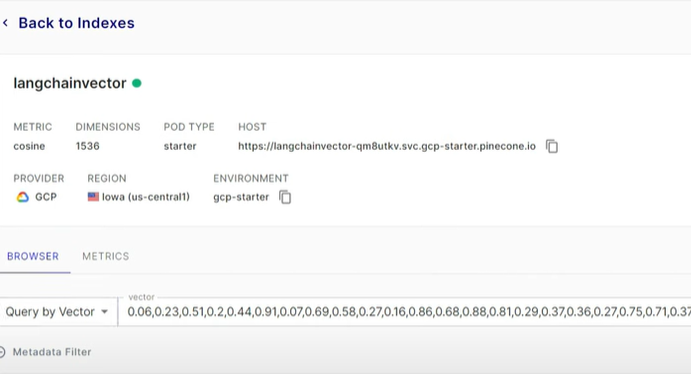

### Retrieving results

- using cosine similarities, I am retriving results from VectorDB

In [ ]:
# function to retrive, index.similarity_search() is function

def retrieve_query(query, k=2): #2-> top 2 queries
    matching_results= index.similarity_search(query, k=k)
    return matching_results


In [ ]:
from langchain.chains.question_answering import load_qa_chain
from langchain import OpenAI

In [ ]:
llm= OpenAI(model_name= "text-davinci-003", temperature= 0.5)
chain= load_qa_chain(llm, chain_type= "stuff")

### Searching from VectorDB

In [ ]:
def retrieve_answers(query):
    doc_search= retrieve_query(query)
    print(doc_search)
    response= chain.run(input_documents=doc_search, question= query)
    return response


In [ ]:
my_query= "How much the agriculture target will be increased by how many crores?"
answer= retrieve_answers(my_query)
print(answer)